# Food Recognition model using PyTorch using Food101 dataset

* author: Amal Varghese
* email: officialamalv2004@gmail.com

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets

print("Using PyTorch version:", torch.__version__)
print("Using torchvision version:", torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Using PyTorch version: 2.7.0+cu118
Using torchvision version: 0.22.0+cu118
Device: cuda


In [7]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up from notebooks/ to project root


# Getting the data ready
- using torchvision datasets
- apply a custom transform

In [4]:
train_data = datasets.Food101(
    root="data",
    split="train",
    download=False,
    transform=train_transform,
)


print(f"Length of train_dataset: {len(train_data.classes)}")

Length of train_dataset: 101


Loading the small dataset using ImageFolder

In [5]:
from pathlib import Path

train_dir = Path("./customdata/train")
test_dir = Path("./customdata/test")

data_dir = Path("./data/food-101/images")
print(train_dir)
print(test_dir)

customdata\train
customdata\test


In [8]:
from helper.data_setup import create_custom_data

create_custom_data(
    data_loc=data_dir,
    train_loc=train_dir,
    test_loc=test_dir,
    classes=train_data.classes,
    size=10,
    train_test_split=80
)

train images for apple_pie: 80
test images for apple_pie: 20



    Train [apple_pie]: 100%|██████████| 80/80 [00:01<00:00, 54.73img/s]


Completed creating customdata\train\apple_pie



    Test [apple_pie]: 100%|██████████| 20/20 [00:00<00:00, 49.61img/s]


Completed creating custom customdata\test\apple_pie
train images for baby_back_ribs: 80
test images for baby_back_ribs: 20



    Train [baby_back_ribs]: 100%|██████████| 80/80 [00:01<00:00, 73.83img/s]


Completed creating customdata\train\baby_back_ribs



    Test [baby_back_ribs]: 100%|██████████| 20/20 [00:00<00:00, 75.03img/s]


Completed creating custom customdata\test\baby_back_ribs
train images for baklava: 80
test images for baklava: 20



    Train [baklava]: 100%|██████████| 80/80 [00:01<00:00, 71.54img/s]


Completed creating customdata\train\baklava



    Test [baklava]: 100%|██████████| 20/20 [00:00<00:00, 79.94img/s]


Completed creating custom customdata\test\baklava
train images for beef_carpaccio: 80
test images for beef_carpaccio: 20



    Train [beef_carpaccio]: 100%|██████████| 80/80 [00:01<00:00, 76.21img/s]


Completed creating customdata\train\beef_carpaccio



    Test [beef_carpaccio]: 100%|██████████| 20/20 [00:00<00:00, 52.81img/s]


Completed creating custom customdata\test\beef_carpaccio
train images for beef_tartare: 80
test images for beef_tartare: 20



    Train [beef_tartare]: 100%|██████████| 80/80 [00:01<00:00, 74.80img/s]


Completed creating customdata\train\beef_tartare



    Test [beef_tartare]: 100%|██████████| 20/20 [00:00<00:00, 73.30img/s]


Completed creating custom customdata\test\beef_tartare
train images for beet_salad: 80
test images for beet_salad: 20



    Train [beet_salad]: 100%|██████████| 80/80 [00:01<00:00, 69.87img/s]


Completed creating customdata\train\beet_salad



    Test [beet_salad]: 100%|██████████| 20/20 [00:00<00:00, 77.55img/s]


Completed creating custom customdata\test\beet_salad
train images for beignets: 80
test images for beignets: 20



    Train [beignets]: 100%|██████████| 80/80 [00:01<00:00, 74.61img/s]


Completed creating customdata\train\beignets



    Test [beignets]: 100%|██████████| 20/20 [00:00<00:00, 59.40img/s]


Completed creating custom customdata\test\beignets
train images for bibimbap: 80
test images for bibimbap: 20



    Train [bibimbap]: 100%|██████████| 80/80 [00:01<00:00, 75.20img/s]


Completed creating customdata\train\bibimbap



    Test [bibimbap]: 100%|██████████| 20/20 [00:00<00:00, 72.01img/s]


Completed creating custom customdata\test\bibimbap
train images for bread_pudding: 80
test images for bread_pudding: 20



    Train [bread_pudding]: 100%|██████████| 80/80 [00:01<00:00, 73.16img/s]


Completed creating customdata\train\bread_pudding



    Test [bread_pudding]: 100%|██████████| 20/20 [00:00<00:00, 74.58img/s]


Completed creating custom customdata\test\bread_pudding
train images for breakfast_burrito: 80
test images for breakfast_burrito: 20



    Train [breakfast_burrito]: 100%|██████████| 80/80 [00:01<00:00, 74.43img/s]


Completed creating customdata\train\breakfast_burrito



    Test [breakfast_burrito]: 100%|██████████| 20/20 [00:00<00:00, 58.13img/s]


Completed creating custom customdata\test\breakfast_burrito
train images for bruschetta: 80
test images for bruschetta: 20



    Train [bruschetta]: 100%|██████████| 80/80 [00:01<00:00, 75.05img/s]


Completed creating customdata\train\bruschetta



    Test [bruschetta]: 100%|██████████| 20/20 [00:00<00:00, 70.83img/s]


Completed creating custom customdata\test\bruschetta
train images for caesar_salad: 80
test images for caesar_salad: 20



    Train [caesar_salad]: 100%|██████████| 80/80 [00:01<00:00, 71.66img/s]


Completed creating customdata\train\caesar_salad



    Test [caesar_salad]: 100%|██████████| 20/20 [00:00<00:00, 75.05img/s]


Completed creating custom customdata\test\caesar_salad
train images for cannoli: 80
test images for cannoli: 20



    Train [cannoli]: 100%|██████████| 80/80 [00:01<00:00, 77.98img/s]


Completed creating customdata\train\cannoli



    Test [cannoli]: 100%|██████████| 20/20 [00:00<00:00, 68.88img/s]


Completed creating custom customdata\test\cannoli
train images for caprese_salad: 80
test images for caprese_salad: 20



    Train [caprese_salad]: 100%|██████████| 80/80 [00:01<00:00, 74.69img/s]


Completed creating customdata\train\caprese_salad



    Test [caprese_salad]: 100%|██████████| 20/20 [00:00<00:00, 70.73img/s]


Completed creating custom customdata\test\caprese_salad
train images for carrot_cake: 80
test images for carrot_cake: 20



    Train [carrot_cake]: 100%|██████████| 80/80 [00:01<00:00, 77.03img/s]


Completed creating customdata\train\carrot_cake



    Test [carrot_cake]: 100%|██████████| 20/20 [00:00<00:00, 72.83img/s]


Completed creating custom customdata\test\carrot_cake
train images for ceviche: 80
test images for ceviche: 20



    Train [ceviche]: 100%|██████████| 80/80 [00:01<00:00, 75.25img/s]


Completed creating customdata\train\ceviche



    Test [ceviche]: 100%|██████████| 20/20 [00:00<00:00, 55.90img/s]


Completed creating custom customdata\test\ceviche
train images for cheese_plate: 80
test images for cheese_plate: 20



    Train [cheese_plate]: 100%|██████████| 80/80 [00:00<00:00, 80.23img/s]


Completed creating customdata\train\cheese_plate



    Test [cheese_plate]: 100%|██████████| 20/20 [00:00<00:00, 78.52img/s]


Completed creating custom customdata\test\cheese_plate
train images for cheesecake: 80
test images for cheesecake: 20



    Train [cheesecake]: 100%|██████████| 80/80 [00:01<00:00, 73.58img/s]


Completed creating customdata\train\cheesecake



    Test [cheesecake]: 100%|██████████| 20/20 [00:00<00:00, 79.78img/s]


Completed creating custom customdata\test\cheesecake
train images for chicken_curry: 80
test images for chicken_curry: 20



    Train [chicken_curry]: 100%|██████████| 80/80 [00:01<00:00, 78.57img/s]


Completed creating customdata\train\chicken_curry



    Test [chicken_curry]: 100%|██████████| 20/20 [00:00<00:00, 60.48img/s]


Completed creating custom customdata\test\chicken_curry
train images for chicken_quesadilla: 80
test images for chicken_quesadilla: 20



    Train [chicken_quesadilla]: 100%|██████████| 80/80 [00:01<00:00, 78.75img/s]


Completed creating customdata\train\chicken_quesadilla



    Test [chicken_quesadilla]: 100%|██████████| 20/20 [00:00<00:00, 76.30img/s]


Completed creating custom customdata\test\chicken_quesadilla
train images for chicken_wings: 80
test images for chicken_wings: 20



    Train [chicken_wings]: 100%|██████████| 80/80 [00:01<00:00, 79.97img/s]


Completed creating customdata\train\chicken_wings



    Test [chicken_wings]: 100%|██████████| 20/20 [00:00<00:00, 75.28img/s]


Completed creating custom customdata\test\chicken_wings
train images for chocolate_cake: 80
test images for chocolate_cake: 20



    Train [chocolate_cake]: 100%|██████████| 80/80 [00:01<00:00, 72.99img/s]


Completed creating customdata\train\chocolate_cake



    Test [chocolate_cake]: 100%|██████████| 20/20 [00:00<00:00, 74.96img/s]


Completed creating custom customdata\test\chocolate_cake
train images for chocolate_mousse: 80
test images for chocolate_mousse: 20



    Train [chocolate_mousse]: 100%|██████████| 80/80 [00:01<00:00, 70.38img/s]


Completed creating customdata\train\chocolate_mousse



    Test [chocolate_mousse]: 100%|██████████| 20/20 [00:00<00:00, 71.62img/s]


Completed creating custom customdata\test\chocolate_mousse
train images for churros: 80
test images for churros: 20



    Train [churros]: 100%|██████████| 80/80 [00:01<00:00, 73.99img/s]


Completed creating customdata\train\churros



    Test [churros]: 100%|██████████| 20/20 [00:00<00:00, 57.28img/s]


Completed creating custom customdata\test\churros
train images for clam_chowder: 80
test images for clam_chowder: 20



    Train [clam_chowder]: 100%|██████████| 80/80 [00:01<00:00, 74.00img/s]


Completed creating customdata\train\clam_chowder



    Test [clam_chowder]: 100%|██████████| 20/20 [00:00<00:00, 74.24img/s]


Completed creating custom customdata\test\clam_chowder
train images for club_sandwich: 80
test images for club_sandwich: 20



    Train [club_sandwich]: 100%|██████████| 80/80 [00:01<00:00, 70.50img/s]


Completed creating customdata\train\club_sandwich



    Test [club_sandwich]: 100%|██████████| 20/20 [00:00<00:00, 75.75img/s]


Completed creating custom customdata\test\club_sandwich
train images for crab_cakes: 80
test images for crab_cakes: 20



    Train [crab_cakes]: 100%|██████████| 80/80 [00:00<00:00, 80.40img/s]


Completed creating customdata\train\crab_cakes



    Test [crab_cakes]: 100%|██████████| 20/20 [00:00<00:00, 81.78img/s]


Completed creating custom customdata\test\crab_cakes
train images for creme_brulee: 80
test images for creme_brulee: 20



    Train [creme_brulee]: 100%|██████████| 80/80 [00:01<00:00, 70.87img/s]


Completed creating customdata\train\creme_brulee



    Test [creme_brulee]: 100%|██████████| 20/20 [00:00<00:00, 71.99img/s]


Completed creating custom customdata\test\creme_brulee
train images for croque_madame: 80
test images for croque_madame: 20



    Train [croque_madame]: 100%|██████████| 80/80 [00:01<00:00, 75.01img/s]


Completed creating customdata\train\croque_madame



    Test [croque_madame]: 100%|██████████| 20/20 [00:00<00:00, 73.02img/s]


Completed creating custom customdata\test\croque_madame
train images for cup_cakes: 80
test images for cup_cakes: 20



    Train [cup_cakes]: 100%|██████████| 80/80 [00:01<00:00, 76.49img/s]


Completed creating customdata\train\cup_cakes



    Test [cup_cakes]: 100%|██████████| 20/20 [00:00<00:00, 76.42img/s]


Completed creating custom customdata\test\cup_cakes
train images for deviled_eggs: 80
test images for deviled_eggs: 20



    Train [deviled_eggs]: 100%|██████████| 80/80 [00:01<00:00, 69.45img/s]


Completed creating customdata\train\deviled_eggs



    Test [deviled_eggs]: 100%|██████████| 20/20 [00:00<00:00, 65.35img/s]


Completed creating custom customdata\test\deviled_eggs
train images for donuts: 80
test images for donuts: 20



    Train [donuts]: 100%|██████████| 80/80 [00:01<00:00, 66.85img/s]


Completed creating customdata\train\donuts



    Test [donuts]: 100%|██████████| 20/20 [00:00<00:00, 79.20img/s]


Completed creating custom customdata\test\donuts
train images for dumplings: 80
test images for dumplings: 20



    Train [dumplings]: 100%|██████████| 80/80 [00:01<00:00, 66.38img/s]


Completed creating customdata\train\dumplings



    Test [dumplings]: 100%|██████████| 20/20 [00:00<00:00, 64.77img/s]


Completed creating custom customdata\test\dumplings
train images for edamame: 80
test images for edamame: 20



    Train [edamame]: 100%|██████████| 80/80 [00:01<00:00, 69.51img/s]


Completed creating customdata\train\edamame



    Test [edamame]: 100%|██████████| 20/20 [00:00<00:00, 66.89img/s]


Completed creating custom customdata\test\edamame
train images for eggs_benedict: 80
test images for eggs_benedict: 20



    Train [eggs_benedict]: 100%|██████████| 80/80 [00:01<00:00, 65.71img/s]


Completed creating customdata\train\eggs_benedict



    Test [eggs_benedict]: 100%|██████████| 20/20 [00:00<00:00, 69.09img/s]


Completed creating custom customdata\test\eggs_benedict
train images for escargots: 80
test images for escargots: 20



    Train [escargots]: 100%|██████████| 80/80 [00:01<00:00, 72.35img/s]


Completed creating customdata\train\escargots



    Test [escargots]: 100%|██████████| 20/20 [00:00<00:00, 56.85img/s]


Completed creating custom customdata\test\escargots
train images for falafel: 80
test images for falafel: 20



    Train [falafel]: 100%|██████████| 80/80 [00:01<00:00, 69.52img/s]


Completed creating customdata\train\falafel



    Test [falafel]: 100%|██████████| 20/20 [00:00<00:00, 70.41img/s]


Completed creating custom customdata\test\falafel
train images for filet_mignon: 80
test images for filet_mignon: 20



    Train [filet_mignon]: 100%|██████████| 80/80 [00:01<00:00, 67.22img/s]


Completed creating customdata\train\filet_mignon



    Test [filet_mignon]: 100%|██████████| 20/20 [00:00<00:00, 70.39img/s]


Completed creating custom customdata\test\filet_mignon
train images for fish_and_chips: 80
test images for fish_and_chips: 20



    Train [fish_and_chips]: 100%|██████████| 80/80 [00:01<00:00, 69.20img/s]


Completed creating customdata\train\fish_and_chips



    Test [fish_and_chips]: 100%|██████████| 20/20 [00:00<00:00, 54.50img/s]


Completed creating custom customdata\test\fish_and_chips
train images for foie_gras: 80
test images for foie_gras: 20



    Train [foie_gras]: 100%|██████████| 80/80 [00:01<00:00, 72.25img/s]


Completed creating customdata\train\foie_gras



    Test [foie_gras]: 100%|██████████| 20/20 [00:00<00:00, 72.62img/s]


Completed creating custom customdata\test\foie_gras
train images for french_fries: 80
test images for french_fries: 20



    Train [french_fries]: 100%|██████████| 80/80 [00:01<00:00, 71.39img/s]


Completed creating customdata\train\french_fries



    Test [french_fries]: 100%|██████████| 20/20 [00:00<00:00, 66.40img/s]


Completed creating custom customdata\test\french_fries
train images for french_onion_soup: 80
test images for french_onion_soup: 20



    Train [french_onion_soup]: 100%|██████████| 80/80 [00:01<00:00, 70.78img/s]


Completed creating customdata\train\french_onion_soup



    Test [french_onion_soup]: 100%|██████████| 20/20 [00:00<00:00, 70.62img/s]


Completed creating custom customdata\test\french_onion_soup
train images for french_toast: 80
test images for french_toast: 20



    Train [french_toast]: 100%|██████████| 80/80 [00:01<00:00, 68.00img/s]


Completed creating customdata\train\french_toast



    Test [french_toast]: 100%|██████████| 20/20 [00:00<00:00, 72.50img/s]


Completed creating custom customdata\test\french_toast
train images for fried_calamari: 80
test images for fried_calamari: 20



    Train [fried_calamari]: 100%|██████████| 80/80 [00:01<00:00, 69.70img/s]


Completed creating customdata\train\fried_calamari



    Test [fried_calamari]: 100%|██████████| 20/20 [00:00<00:00, 68.24img/s]


Completed creating custom customdata\test\fried_calamari
train images for fried_rice: 80
test images for fried_rice: 20



    Train [fried_rice]: 100%|██████████| 80/80 [00:01<00:00, 66.39img/s]


Completed creating customdata\train\fried_rice



    Test [fried_rice]: 100%|██████████| 20/20 [00:00<00:00, 63.89img/s]


Completed creating custom customdata\test\fried_rice
train images for frozen_yogurt: 80
test images for frozen_yogurt: 20



    Train [frozen_yogurt]: 100%|██████████| 80/80 [00:01<00:00, 66.64img/s]


Completed creating customdata\train\frozen_yogurt



    Test [frozen_yogurt]: 100%|██████████| 20/20 [00:00<00:00, 72.91img/s]


Completed creating custom customdata\test\frozen_yogurt
train images for garlic_bread: 80
test images for garlic_bread: 20



    Train [garlic_bread]: 100%|██████████| 80/80 [00:01<00:00, 71.91img/s]


Completed creating customdata\train\garlic_bread



    Test [garlic_bread]: 100%|██████████| 20/20 [00:00<00:00, 74.93img/s]


Completed creating custom customdata\test\garlic_bread
train images for gnocchi: 80
test images for gnocchi: 20



    Train [gnocchi]: 100%|██████████| 80/80 [00:01<00:00, 67.83img/s]


Completed creating customdata\train\gnocchi



    Test [gnocchi]: 100%|██████████| 20/20 [00:00<00:00, 67.96img/s]


Completed creating custom customdata\test\gnocchi
train images for greek_salad: 80
test images for greek_salad: 20



    Train [greek_salad]: 100%|██████████| 80/80 [00:01<00:00, 63.12img/s]


Completed creating customdata\train\greek_salad



    Test [greek_salad]: 100%|██████████| 20/20 [00:00<00:00, 67.46img/s]


Completed creating custom customdata\test\greek_salad
train images for grilled_cheese_sandwich: 80
test images for grilled_cheese_sandwich: 20



    Train [grilled_cheese_sandwich]: 100%|██████████| 80/80 [00:01<00:00, 70.88img/s]


Completed creating customdata\train\grilled_cheese_sandwich



    Test [grilled_cheese_sandwich]: 100%|██████████| 20/20 [00:00<00:00, 74.49img/s]


Completed creating custom customdata\test\grilled_cheese_sandwich
train images for grilled_salmon: 80
test images for grilled_salmon: 20



    Train [grilled_salmon]: 100%|██████████| 80/80 [00:01<00:00, 69.46img/s]


Completed creating customdata\train\grilled_salmon



    Test [grilled_salmon]: 100%|██████████| 20/20 [00:00<00:00, 70.61img/s]


Completed creating custom customdata\test\grilled_salmon
train images for guacamole: 80
test images for guacamole: 20



    Train [guacamole]: 100%|██████████| 80/80 [00:01<00:00, 71.57img/s]


Completed creating customdata\train\guacamole



    Test [guacamole]: 100%|██████████| 20/20 [00:00<00:00, 55.52img/s]


Completed creating custom customdata\test\guacamole
train images for gyoza: 80
test images for gyoza: 20



    Train [gyoza]: 100%|██████████| 80/80 [00:01<00:00, 65.61img/s]


Completed creating customdata\train\gyoza



    Test [gyoza]: 100%|██████████| 20/20 [00:00<00:00, 70.25img/s]


Completed creating custom customdata\test\gyoza
train images for hamburger: 80
test images for hamburger: 20



    Train [hamburger]: 100%|██████████| 80/80 [00:01<00:00, 64.44img/s]


Completed creating customdata\train\hamburger



    Test [hamburger]: 100%|██████████| 20/20 [00:00<00:00, 79.82img/s]


Completed creating custom customdata\test\hamburger
train images for hot_and_sour_soup: 80
test images for hot_and_sour_soup: 20



    Train [hot_and_sour_soup]: 100%|██████████| 80/80 [00:01<00:00, 75.11img/s]


Completed creating customdata\train\hot_and_sour_soup



    Test [hot_and_sour_soup]: 100%|██████████| 20/20 [00:00<00:00, 70.49img/s]


Completed creating custom customdata\test\hot_and_sour_soup
train images for hot_dog: 80
test images for hot_dog: 20



    Train [hot_dog]: 100%|██████████| 80/80 [00:01<00:00, 77.46img/s]


Completed creating customdata\train\hot_dog



    Test [hot_dog]: 100%|██████████| 20/20 [00:00<00:00, 72.79img/s]


Completed creating custom customdata\test\hot_dog
train images for huevos_rancheros: 80
test images for huevos_rancheros: 20



    Train [huevos_rancheros]: 100%|██████████| 80/80 [00:01<00:00, 71.42img/s]


Completed creating customdata\train\huevos_rancheros



    Test [huevos_rancheros]: 100%|██████████| 20/20 [00:00<00:00, 69.69img/s]


Completed creating custom customdata\test\huevos_rancheros
train images for hummus: 80
test images for hummus: 20



    Train [hummus]: 100%|██████████| 80/80 [00:01<00:00, 75.88img/s]


Completed creating customdata\train\hummus



    Test [hummus]: 100%|██████████| 20/20 [00:00<00:00, 59.64img/s]


Completed creating custom customdata\test\hummus
train images for ice_cream: 80
test images for ice_cream: 20



    Train [ice_cream]: 100%|██████████| 80/80 [00:00<00:00, 80.20img/s]


Completed creating customdata\train\ice_cream



    Test [ice_cream]: 100%|██████████| 20/20 [00:00<00:00, 68.58img/s]


Completed creating custom customdata\test\ice_cream
train images for lasagna: 80
test images for lasagna: 20



    Train [lasagna]: 100%|██████████| 80/80 [00:01<00:00, 67.85img/s]


Completed creating customdata\train\lasagna



    Test [lasagna]: 100%|██████████| 20/20 [00:00<00:00, 66.96img/s]


Completed creating custom customdata\test\lasagna
train images for lobster_bisque: 80
test images for lobster_bisque: 20



    Train [lobster_bisque]: 100%|██████████| 80/80 [00:01<00:00, 66.71img/s]


Completed creating customdata\train\lobster_bisque



    Test [lobster_bisque]: 100%|██████████| 20/20 [00:00<00:00, 72.24img/s]


Completed creating custom customdata\test\lobster_bisque
train images for lobster_roll_sandwich: 80
test images for lobster_roll_sandwich: 20



    Train [lobster_roll_sandwich]: 100%|██████████| 80/80 [00:01<00:00, 72.58img/s]


Completed creating customdata\train\lobster_roll_sandwich



    Test [lobster_roll_sandwich]: 100%|██████████| 20/20 [00:00<00:00, 62.26img/s]


Completed creating custom customdata\test\lobster_roll_sandwich
train images for macaroni_and_cheese: 80
test images for macaroni_and_cheese: 20



    Train [macaroni_and_cheese]: 100%|██████████| 80/80 [00:01<00:00, 72.10img/s]


Completed creating customdata\train\macaroni_and_cheese



    Test [macaroni_and_cheese]: 100%|██████████| 20/20 [00:00<00:00, 77.62img/s]


Completed creating custom customdata\test\macaroni_and_cheese
train images for macarons: 80
test images for macarons: 20



    Train [macarons]: 100%|██████████| 80/80 [00:01<00:00, 74.58img/s]


Completed creating customdata\train\macarons



    Test [macarons]: 100%|██████████| 20/20 [00:00<00:00, 71.28img/s]


Completed creating custom customdata\test\macarons
train images for miso_soup: 80
test images for miso_soup: 20



    Train [miso_soup]: 100%|██████████| 80/80 [00:01<00:00, 68.51img/s]


Completed creating customdata\train\miso_soup



    Test [miso_soup]: 100%|██████████| 20/20 [00:00<00:00, 70.22img/s]


Completed creating custom customdata\test\miso_soup
train images for mussels: 80
test images for mussels: 20



    Train [mussels]: 100%|██████████| 80/80 [00:01<00:00, 69.66img/s]


Completed creating customdata\train\mussels



    Test [mussels]: 100%|██████████| 20/20 [00:00<00:00, 81.30img/s]


Completed creating custom customdata\test\mussels
train images for nachos: 80
test images for nachos: 20



    Train [nachos]: 100%|██████████| 80/80 [00:01<00:00, 68.98img/s]


Completed creating customdata\train\nachos



    Test [nachos]: 100%|██████████| 20/20 [00:00<00:00, 75.10img/s]


Completed creating custom customdata\test\nachos
train images for omelette: 80
test images for omelette: 20



    Train [omelette]: 100%|██████████| 80/80 [00:01<00:00, 73.34img/s]


Completed creating customdata\train\omelette



    Test [omelette]: 100%|██████████| 20/20 [00:00<00:00, 79.45img/s]


Completed creating custom customdata\test\omelette
train images for onion_rings: 80
test images for onion_rings: 20



    Train [onion_rings]: 100%|██████████| 80/80 [00:01<00:00, 74.92img/s]


Completed creating customdata\train\onion_rings



    Test [onion_rings]: 100%|██████████| 20/20 [00:00<00:00, 72.08img/s]


Completed creating custom customdata\test\onion_rings
train images for oysters: 80
test images for oysters: 20



    Train [oysters]: 100%|██████████| 80/80 [00:00<00:00, 80.55img/s]


Completed creating customdata\train\oysters



    Test [oysters]: 100%|██████████| 20/20 [00:00<00:00, 74.19img/s]


Completed creating custom customdata\test\oysters
train images for pad_thai: 80
test images for pad_thai: 20



    Train [pad_thai]: 100%|██████████| 80/80 [00:01<00:00, 78.35img/s]


Completed creating customdata\train\pad_thai



    Test [pad_thai]: 100%|██████████| 20/20 [00:00<00:00, 69.38img/s]


Completed creating custom customdata\test\pad_thai
train images for paella: 80
test images for paella: 20



    Train [paella]: 100%|██████████| 80/80 [00:01<00:00, 69.66img/s]


Completed creating customdata\train\paella



    Test [paella]: 100%|██████████| 20/20 [00:00<00:00, 70.21img/s]


Completed creating custom customdata\test\paella
train images for pancakes: 80
test images for pancakes: 20



    Train [pancakes]: 100%|██████████| 80/80 [00:01<00:00, 76.34img/s]


Completed creating customdata\train\pancakes



    Test [pancakes]: 100%|██████████| 20/20 [00:00<00:00, 57.07img/s]


Completed creating custom customdata\test\pancakes
train images for panna_cotta: 80
test images for panna_cotta: 20



    Train [panna_cotta]: 100%|██████████| 80/80 [00:01<00:00, 67.35img/s]


Completed creating customdata\train\panna_cotta



    Test [panna_cotta]: 100%|██████████| 20/20 [00:00<00:00, 76.77img/s]


Completed creating custom customdata\test\panna_cotta
train images for peking_duck: 80
test images for peking_duck: 20



    Train [peking_duck]: 100%|██████████| 80/80 [00:01<00:00, 74.78img/s]


Completed creating customdata\train\peking_duck



    Test [peking_duck]: 100%|██████████| 20/20 [00:00<00:00, 70.49img/s]


Completed creating custom customdata\test\peking_duck
train images for pho: 80
test images for pho: 20



    Train [pho]: 100%|██████████| 80/80 [00:01<00:00, 73.84img/s]


Completed creating customdata\train\pho



    Test [pho]: 100%|██████████| 20/20 [00:00<00:00, 74.49img/s]


Completed creating custom customdata\test\pho
train images for pizza: 80
test images for pizza: 20



    Train [pizza]: 100%|██████████| 80/80 [00:01<00:00, 69.44img/s]


Completed creating customdata\train\pizza



    Test [pizza]: 100%|██████████| 20/20 [00:00<00:00, 75.47img/s]


Completed creating custom customdata\test\pizza
train images for pork_chop: 80
test images for pork_chop: 20



    Train [pork_chop]: 100%|██████████| 80/80 [00:01<00:00, 74.95img/s]


Completed creating customdata\train\pork_chop



    Test [pork_chop]: 100%|██████████| 20/20 [00:00<00:00, 61.27img/s]


Completed creating custom customdata\test\pork_chop
train images for poutine: 80
test images for poutine: 20



    Train [poutine]: 100%|██████████| 80/80 [00:01<00:00, 73.09img/s]


Completed creating customdata\train\poutine



    Test [poutine]: 100%|██████████| 20/20 [00:00<00:00, 75.39img/s]


Completed creating custom customdata\test\poutine
train images for prime_rib: 80
test images for prime_rib: 20



    Train [prime_rib]: 100%|██████████| 80/80 [00:01<00:00, 70.10img/s]


Completed creating customdata\train\prime_rib



    Test [prime_rib]: 100%|██████████| 20/20 [00:00<00:00, 77.71img/s]


Completed creating custom customdata\test\prime_rib
train images for pulled_pork_sandwich: 80
test images for pulled_pork_sandwich: 20



    Train [pulled_pork_sandwich]: 100%|██████████| 80/80 [00:01<00:00, 78.43img/s]


Completed creating customdata\train\pulled_pork_sandwich



    Test [pulled_pork_sandwich]: 100%|██████████| 20/20 [00:00<00:00, 69.32img/s]


Completed creating custom customdata\test\pulled_pork_sandwich
train images for ramen: 80
test images for ramen: 20



    Train [ramen]: 100%|██████████| 80/80 [00:01<00:00, 70.82img/s]


Completed creating customdata\train\ramen



    Test [ramen]: 100%|██████████| 20/20 [00:00<00:00, 48.25img/s]


Completed creating custom customdata\test\ramen
train images for ravioli: 80
test images for ravioli: 20



    Train [ravioli]: 100%|██████████| 80/80 [00:01<00:00, 72.99img/s]


Completed creating customdata\train\ravioli



    Test [ravioli]: 100%|██████████| 20/20 [00:00<00:00, 65.24img/s]


Completed creating custom customdata\test\ravioli
train images for red_velvet_cake: 80
test images for red_velvet_cake: 20



    Train [red_velvet_cake]: 100%|██████████| 80/80 [00:01<00:00, 69.60img/s]


Completed creating customdata\train\red_velvet_cake



    Test [red_velvet_cake]: 100%|██████████| 20/20 [00:00<00:00, 75.50img/s]


Completed creating custom customdata\test\red_velvet_cake
train images for risotto: 80
test images for risotto: 20



    Train [risotto]: 100%|██████████| 80/80 [00:01<00:00, 68.15img/s]


Completed creating customdata\train\risotto



    Test [risotto]: 100%|██████████| 20/20 [00:00<00:00, 63.68img/s]


Completed creating custom customdata\test\risotto
train images for samosa: 80
test images for samosa: 20



    Train [samosa]: 100%|██████████| 80/80 [00:01<00:00, 71.69img/s]


Completed creating customdata\train\samosa



    Test [samosa]: 100%|██████████| 20/20 [00:00<00:00, 60.23img/s]


Completed creating custom customdata\test\samosa
train images for sashimi: 80
test images for sashimi: 20



    Train [sashimi]: 100%|██████████| 80/80 [00:01<00:00, 70.44img/s]


Completed creating customdata\train\sashimi



    Test [sashimi]: 100%|██████████| 20/20 [00:00<00:00, 71.97img/s]


Completed creating custom customdata\test\sashimi
train images for scallops: 80
test images for scallops: 20



    Train [scallops]: 100%|██████████| 80/80 [00:01<00:00, 63.52img/s]


Completed creating customdata\train\scallops



    Test [scallops]: 100%|██████████| 20/20 [00:00<00:00, 69.20img/s]


Completed creating custom customdata\test\scallops
train images for seaweed_salad: 80
test images for seaweed_salad: 20



    Train [seaweed_salad]: 100%|██████████| 80/80 [00:01<00:00, 66.38img/s]


Completed creating customdata\train\seaweed_salad



    Test [seaweed_salad]: 100%|██████████| 20/20 [00:00<00:00, 68.03img/s]


Completed creating custom customdata\test\seaweed_salad
train images for shrimp_and_grits: 80
test images for shrimp_and_grits: 20



    Train [shrimp_and_grits]: 100%|██████████| 80/80 [00:01<00:00, 67.99img/s]


Completed creating customdata\train\shrimp_and_grits



    Test [shrimp_and_grits]: 100%|██████████| 20/20 [00:00<00:00, 59.35img/s]


Completed creating custom customdata\test\shrimp_and_grits
train images for spaghetti_bolognese: 80
test images for spaghetti_bolognese: 20



    Train [spaghetti_bolognese]: 100%|██████████| 80/80 [00:01<00:00, 58.46img/s]


Completed creating customdata\train\spaghetti_bolognese



    Test [spaghetti_bolognese]: 100%|██████████| 20/20 [00:00<00:00, 66.54img/s]


Completed creating custom customdata\test\spaghetti_bolognese
train images for spaghetti_carbonara: 80
test images for spaghetti_carbonara: 20



    Train [spaghetti_carbonara]: 100%|██████████| 80/80 [00:01<00:00, 56.18img/s]


Completed creating customdata\train\spaghetti_carbonara



    Test [spaghetti_carbonara]: 100%|██████████| 20/20 [00:00<00:00, 52.87img/s]


Completed creating custom customdata\test\spaghetti_carbonara
train images for spring_rolls: 80
test images for spring_rolls: 20



    Train [spring_rolls]: 100%|██████████| 80/80 [00:01<00:00, 58.92img/s]


Completed creating customdata\train\spring_rolls



    Test [spring_rolls]: 100%|██████████| 20/20 [00:00<00:00, 61.05img/s]


Completed creating custom customdata\test\spring_rolls
train images for steak: 80
test images for steak: 20



    Train [steak]: 100%|██████████| 80/80 [00:01<00:00, 63.35img/s]


Completed creating customdata\train\steak



    Test [steak]: 100%|██████████| 20/20 [00:00<00:00, 55.14img/s]


Completed creating custom customdata\test\steak
train images for strawberry_shortcake: 80
test images for strawberry_shortcake: 20



    Train [strawberry_shortcake]: 100%|██████████| 80/80 [00:01<00:00, 67.98img/s]


Completed creating customdata\train\strawberry_shortcake



    Test [strawberry_shortcake]: 100%|██████████| 20/20 [00:00<00:00, 64.82img/s]


Completed creating custom customdata\test\strawberry_shortcake
train images for sushi: 80
test images for sushi: 20



    Train [sushi]: 100%|██████████| 80/80 [00:01<00:00, 59.11img/s]


Completed creating customdata\train\sushi



    Test [sushi]: 100%|██████████| 20/20 [00:00<00:00, 43.15img/s]


Completed creating custom customdata\test\sushi
train images for tacos: 80
test images for tacos: 20



    Train [tacos]: 100%|██████████| 80/80 [00:01<00:00, 61.69img/s]


Completed creating customdata\train\tacos



    Test [tacos]: 100%|██████████| 20/20 [00:00<00:00, 61.55img/s]


Completed creating custom customdata\test\tacos
train images for takoyaki: 80
test images for takoyaki: 20



    Train [takoyaki]: 100%|██████████| 80/80 [00:01<00:00, 58.42img/s]


Completed creating customdata\train\takoyaki



    Test [takoyaki]: 100%|██████████| 20/20 [00:00<00:00, 64.27img/s]


Completed creating custom customdata\test\takoyaki
train images for tiramisu: 80
test images for tiramisu: 20



    Train [tiramisu]: 100%|██████████| 80/80 [00:01<00:00, 58.23img/s]


Completed creating customdata\train\tiramisu



    Test [tiramisu]: 100%|██████████| 20/20 [00:00<00:00, 64.77img/s]


Completed creating custom customdata\test\tiramisu
train images for tuna_tartare: 80
test images for tuna_tartare: 20



    Train [tuna_tartare]: 100%|██████████| 80/80 [00:01<00:00, 65.86img/s]


Completed creating customdata\train\tuna_tartare



    Test [tuna_tartare]: 100%|██████████| 20/20 [00:00<00:00, 56.54img/s]


Completed creating custom customdata\test\tuna_tartare
train images for waffles: 80
test images for waffles: 20



    Train [waffles]: 100%|██████████| 80/80 [00:01<00:00, 67.68img/s]


Completed creating customdata\train\waffles



    Test [waffles]: 100%|██████████| 20/20 [00:00<00:00, 60.01img/s]

Completed creating custom customdata\test\waffles


In [9]:
from torchvision import transforms

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # transforms.TrivialAugmentWide(),  # Still lightweight
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224 , 224)),
    transforms.ToTensor(),
    transforms.Normalize(                     # Normalize to ImageNet mean/std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print(f"Train transform: {train_transform}")
print(f"Test transform: {test_transform}")

Train transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Test transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [10]:
from torchvision.datasets import ImageFolder

train_dataset_simple = ImageFolder(
    root=train_dir,
    transform=train_transform
)

test_dataset_simple = ImageFolder(
    root=test_dir,
    transform=test_transform
)

print(train_dataset_simple)
print(test_dataset_simple)

Dataset ImageFolder
    Number of datapoints: 35936
    Root location: customdata\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 11909
    Root location: customdata\test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


# Exploartory Data Analysis

In [14]:
image, label = train_data[0]
print(f"Image Shape: {image.shape} -> [color channels , height, width]")
classes = train_data.classes
print(f"Total number of classes:{len(classes)}")

Image Shape: torch.Size([3, 224, 224]) -> [color channels , height, width]
Total number of classes:101


In [13]:
image, label = train_dataset_simple[0]
print(f"Image Shape: {image.shape} -> [color channels, height, width]")
classes_ = train_dataset_simple.classes
print(f"Total number of classes:{len(classes_)}")
print(f"No. of train images: {len(train_dataset_simple)}")
print(f"No. of test images: {len(test_dataset_simple)}")

Image Shape: torch.Size([3, 224, 224]) -> [color channels, height, width]
Total number of classes:101
No. of train images: 35936
No. of test images: 11909


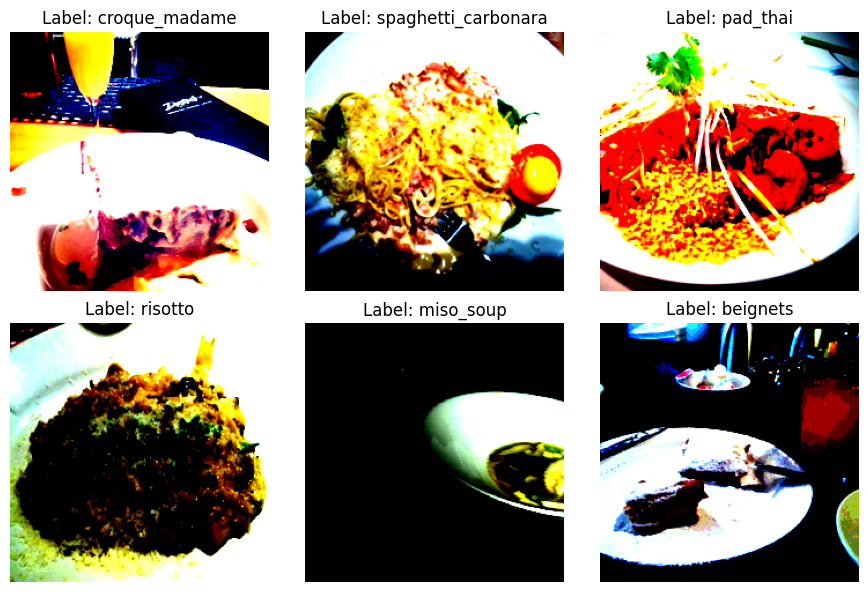

In [11]:
from helper.Visualize import plot_random_images
from helper.Visualize import plot_image

plot_random_images(train_data , num=6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


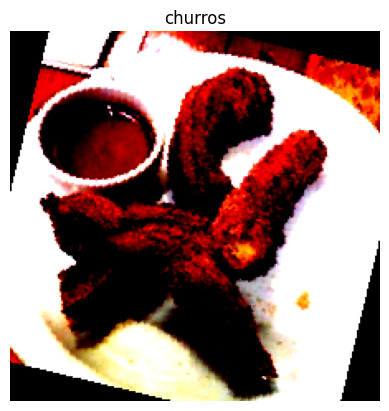

In [15]:
plot_image(train_data[0][0] , classes[train_data[0][1]])

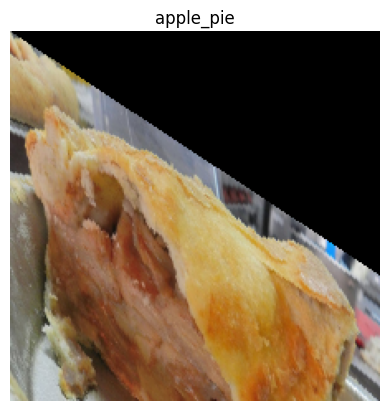

In [11]:
plot_image(train_dataset_simple[10][0], classes_[train_dataset_simple[10][1]])

# Creating Model

* starting with TinyVGG

create a model instance

In [16]:
from models.modelclass.models import TinyVGG

model_0 = TinyVGG(3 , 100 , len(classes_)).to(device)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [17]:
image, label = train_dataset_simple[0]
# Add batch dimension
image = image.unsqueeze(0)
model_0(image.to(device))

tensor([[-4.4839e-01, -4.2188e-01,  7.1519e-01, -9.9836e-01,  1.5193e-02,
         -2.0119e-01, -3.4781e-01, -5.8435e-01,  2.8473e-02, -8.5305e-01,
          3.4418e-01, -5.0414e-01,  3.4280e-01,  4.9703e-01, -3.2192e-02,
         -7.6760e-01, -3.6647e-01,  1.1700e+00,  5.4626e-01, -6.8312e-01,
          3.6826e-01,  9.5276e-01, -6.9435e-01,  6.3881e-01, -1.4839e+00,
          4.7568e-02, -1.9382e+00, -4.6575e-01,  1.3192e-01, -5.6152e-01,
          3.8327e-01,  5.6794e-01, -1.2220e+00,  2.8106e-01, -2.1770e-01,
          7.1142e-01, -3.3355e-01, -9.9890e-01,  3.3425e-01,  5.8596e-02,
          1.0084e+00, -9.7970e-03, -5.8274e-02, -3.7395e-01,  7.5965e-01,
         -4.6436e-01, -1.6393e+00, -9.8150e-01, -4.3287e-01, -6.3270e-01,
          9.6397e-02,  8.4374e-01, -6.3506e-01,  1.2589e+00, -1.1767e-01,
         -6.2049e-01, -1.1018e-02,  2.9634e-01, -1.2912e-01,  9.1443e-01,
          7.7706e-01,  1.5966e+00,  6.3441e-01,  6.0766e-01,  1.4034e+00,
          1.3642e-01, -9.3695e-01,  8.

This means that the model is successfully taking image values in the batchified form, so now we need to batchify it in the dataloaded

# creating dataLoader with small dataset

In [19]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_dataset_simple,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

test_dataloader = DataLoader(
    dataset=test_dataset_simple,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(train_dataloader)
print(test_dataloader)

In [16]:
image, label = next(iter(train_dataloader))
print(f"Shape of Image:{image.shape} -> [Batches, color channels, height, weight]")

Shape of Image:torch.Size([8, 3, 224, 224]) -> [Batches, color channels, height, weight]


In [20]:
from torchinfo import summary

summary(model_0 , 
        input_size=(32,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 101]                 --
├─Sequential: 1-1                        [32, 100, 112, 112]       --
│    └─Conv2d: 2-1                       [32, 100, 224, 224]       2,800
│    └─BatchNorm2d: 2-2                  [32, 100, 224, 224]       200
│    └─ReLU: 2-3                         [32, 100, 224, 224]       --
│    └─Conv2d: 2-4                       [32, 100, 224, 224]       90,100
│    └─BatchNorm2d: 2-5                  [32, 100, 224, 224]       200
│    └─ReLU: 2-6                         [32, 100, 224, 224]       --
│    └─MaxPool2d: 2-7                    [32, 100, 112, 112]       --
│    └─Dropout2d: 2-8                    [32, 100, 112, 112]       --
├─Sequential: 1-2                        [32, 100, 56, 56]         --
│    └─Conv2d: 2-9                       [32, 100, 112, 112]       90,100
│    └─BatchNorm2d: 2-10                 [32, 100, 112, 112]       200
│

# performing training and testing on the model
- peforming on 3 classes and a smaller dataset for benchmark test

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="min",
                                                       patience=5,
                                                       factor=0.1)

In [ ]:
from helper.Process import run_train_test

result = run_train_test(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=torch.device(device),
    epochs=3
)

starting....


  0%|          | 0/3 [00:00<?, ?it/s]

[] Allocated: 249.69 MB | Reserved: 2154.00 MB
